In [1]:
import numpy as np
import pickle
import random 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers



# Load training images
train_images = pickle.load(open("full_CNN_train.p", "rb" ))

# Load image labels
labels = pickle.load(open("full_CNN_labels.p", "rb" ))



Using TensorFlow backend.


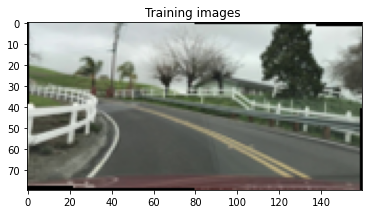

(80, 160, 3)
(80, 160)


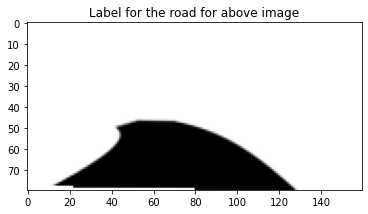

In [2]:
# See training images and labels 

examp=random.randrange(0,len(train_images))

# plot the image 
plt.title("Training images ")
plt.imshow(train_images[examp])
plt.show()

# plot the label 
print(train_images[examp].shape)
plt.title("Label for the road for above image")
labels_examp = labels[examp].reshape(80, 160,) # convert a 3d with one layer to 2d to plot 
print(labels_examp.shape)
plt.imshow(labels_examp,cmap='Greys')
plt.show()

labels[examp].reshape(80, 160,1)    # convert it back to 3d 
print()

In [3]:
# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)


# Normalize labels - training images get normalized to start in the network
labels = labels / 255



In [4]:
# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

In [5]:
# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 64
epochs = 10
pool_size = (2, 2)
input_shape = X_train.shape[1:]

X_train.shape

(11487, 80, 160, 3)

In [6]:
### Here is the actual neural network ###
model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
model.add(BatchNormalization(input_shape=input_shape))

# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))

# Conv Layer 4
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
model.add(Dropout(0.2))

# Conv Layer 5
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
model.add(Dropout(0.2))

# Pooling 2
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 6
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
model.add(Dropout(0.2))

# Conv Layer 7
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(Dropout(0.2))

# Pooling 3
model.add(MaxPooling2D(pool_size=pool_size))


In [7]:
# Upsample 1
model.add(UpSampling2D(size=pool_size))

# Deconv 1
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))

# Deconv 2
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
model.add(Dropout(0.2))

# Upsample 2
model.add(UpSampling2D(size=pool_size))

# Deconv 3
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
model.add(Dropout(0.2))

# Deconv 4
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
model.add(Dropout(0.2))

# Deconv 5
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(Dropout(0.2))

# Upsample 3
model.add(UpSampling2D(size=pool_size))

# Deconv 6
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

# Final layer - only including one channel so 1 filter
model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

### End of network ###

In [8]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2,brightness_range=[0.4,1.4])
datagen.fit(X_train)

In [9]:
# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
180/179 [==============================] - 49s 274ms/step - loss: 0.0408 - val_loss: 0.0183
Epoch 2/10
180/179 [==============================] - 33s 183ms/step - loss: 0.0128 - val_loss: 0.0094
Epoch 3/10
180/179 [==============================] - 33s 183ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 4/10
180/179 [==============================] - 33s 184ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 5/10
180/179 [==============================] - 33s 183ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 6/10
180/179 [==============================] - 33s 184ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 7/10
180/179 [==============================] - 33s 184ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 8/10
180/179 [==============================] - 33s 184ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 9/10
180/179 [==============================] - 33s 184ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 10/10
180/179 [==============================] - 33s 184ms/step - l

In [10]:
# Freeze layers since training is done
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')


In [12]:
# Save model architecture and weights
model.save('full_CNN_model_bright.h5')

# Show summary of model
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 80, 160, 3)        12        
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 158, 8)        224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 76, 156, 16)       1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 78, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 36, 76, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 76, 16)        0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 34, 74, 32)       